In [1]:
%load_ext autotime
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.extend(["../"])

time: 418 µs


In [3]:
from sklearn.model_selection import train_test_split
from core.tools.data_import import *
from core.tools.time_series import *
from constants import *

time: 131 ms


In [4]:
from pprint import pprint
pprint(UNRATE_DIR)
file_dir_selected = input("Select Directory ")

{'EC2': '/home/ec2-user/code/AnnEconForecast/data/UNRATE.csv',
 'MAC': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv'}
Select Directory EC2
time: 2 s


In [5]:
df = load_dataset(UNRATE_DIR[file_dir_selected])
df_d1 = differencing(df, periods=1, order=1)
LAGS = 60

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64
time: 14.7 ms


In [6]:
X_raw, y_raw = gen_supervised_rnn(df_d1, LAGS)

time: 60.2 ms


In [18]:
(X_train, X_test,
 y_train, y_test) = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    shuffle=False
)

(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_train, y_train,
    test_size=0.2,
    shuffle=False
)

time: 1.82 ms


In [19]:
X_scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
y_scaler = sklearn.preprocessing.StandardScaler().fit(y_train)

time: 2.07 ms


In [20]:
tx = lambda target: X_scaler.transform(target)
ty = lambda target: y_scaler.transform(target)

X_train = tx(X_train)
X_test = tx(X_test)
X_val = tx(X_val)

y_train = ty(y_train)
y_test = ty(y_test)
y_val = ty(y_val)

time: 2.13 ms


In [24]:
print(np.std(X_train))
print(np.std(y_train))

1.0000000000000002
1.0000000000000002
time: 1.53 ms


In [25]:
# Expand dimension so it fits the RNN input place holder.
# (Num_Sample, )
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_val = np.expand_dims(X_val, axis=2)

y_train = np.expand_dims(y_train, axis=2)
y_test = np.expand_dims(y_test, axis=2)
y_val = np.expand_dims(y_val, axis=2)

time: 881 µs


In [26]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_test shape: {X_test.shape}\
\ny_test shape: {y_test.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (504, 60, 1)
y_train shape: (504, 60, 1)
X_test shape: (158, 60, 1)
y_test shape: (158, 60, 1)
X_validation shape: (126, 60, 1)
y_validation shape: (126, 60, 1)
time: 580 µs


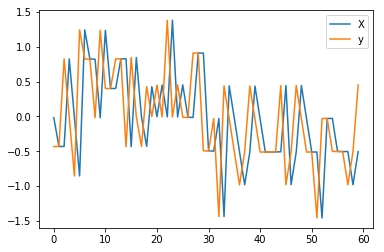

time: 131 ms


In [27]:
plt.plot(X_train[-1])
plt.plot(y_train[-1])
plt.legend(["X", "y"])
plt.show()

In [28]:
num_time_steps = LAGS
# Number of series used to predict. (including concurrent)
num_inputs = 1
num_neurons = 64
# Number of output series
num_outputs = 1
learning_rate = 0.1
epochs = 300
# Training Settings
REPORT_PERIOD = 100

time: 602 µs


In [29]:
tf.reset_default_graph()
# setting up
X = tf.placeholder(
    tf.float32,
    [None, num_time_steps, num_inputs],
    name="Input_placeholder")
y = tf.placeholder(
    tf.float32,
    [None, num_time_steps, num_outputs],
    name="Output_placeholder")

time: 12.3 ms


In [30]:
# Build RNN.
cell = tf.contrib.rnn.LSTMCell(
    num_units=num_neurons
)
    
rnn_output, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
stacked_rnn_output = tf.reshape(rnn_output, [-1, num_neurons])

stacked_outputs = tf.layers.dense(stacked_rnn_output, num_outputs)
outputs = tf.reshape(stacked_outputs, [-1, num_time_steps, num_outputs])

time: 3.63 s


In [31]:
# Operators
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

time: 218 ms


In [32]:
hist = {"train": [], "val": []}
with tf.Session() as sess:
    sess.run(init)
    for e in range(epochs):
        sess.run(train,
                 feed_dict={X: X_train, y: y_train})
        if e % REPORT_PERIOD == 0:
            train_mse = loss.eval(feed_dict={X: X_train, y: y_train})
#             print(f"Iteratin [{e}]: Training MSE {train_mse}")
            val_mse = loss.eval(feed_dict={X: X_val, y: y_val})
            hist["train"].append(train_mse)
            hist["val"].append(val_mse)
            print(f"Iteration [{e}], Training MSE {train_mse:0.7f}; Validation MSE {val_mse:0.7f}")
    
    gen_pred = lambda src: outputs.eval(feed_dict={X: src})[:,-1]
    p_train = gen_pred(X_train)
    p_test = gen_pred(X_test)
    

Iteration [0], Training MSE 0.9869853; Validation MSE 0.3860432
Iteration [100], Training MSE 0.9471784; Validation MSE 0.3799767
Iteration [200], Training MSE 0.9115437; Validation MSE 0.3811324
time: 26.5 s


In [37]:
# clean = lambda x: np.squeeze(x[:, -1: ])
# pred_train = clean(pred_train)
# pred_val = clean(pred_val)
# pred_test = clean(pred_test)

time: 287 µs


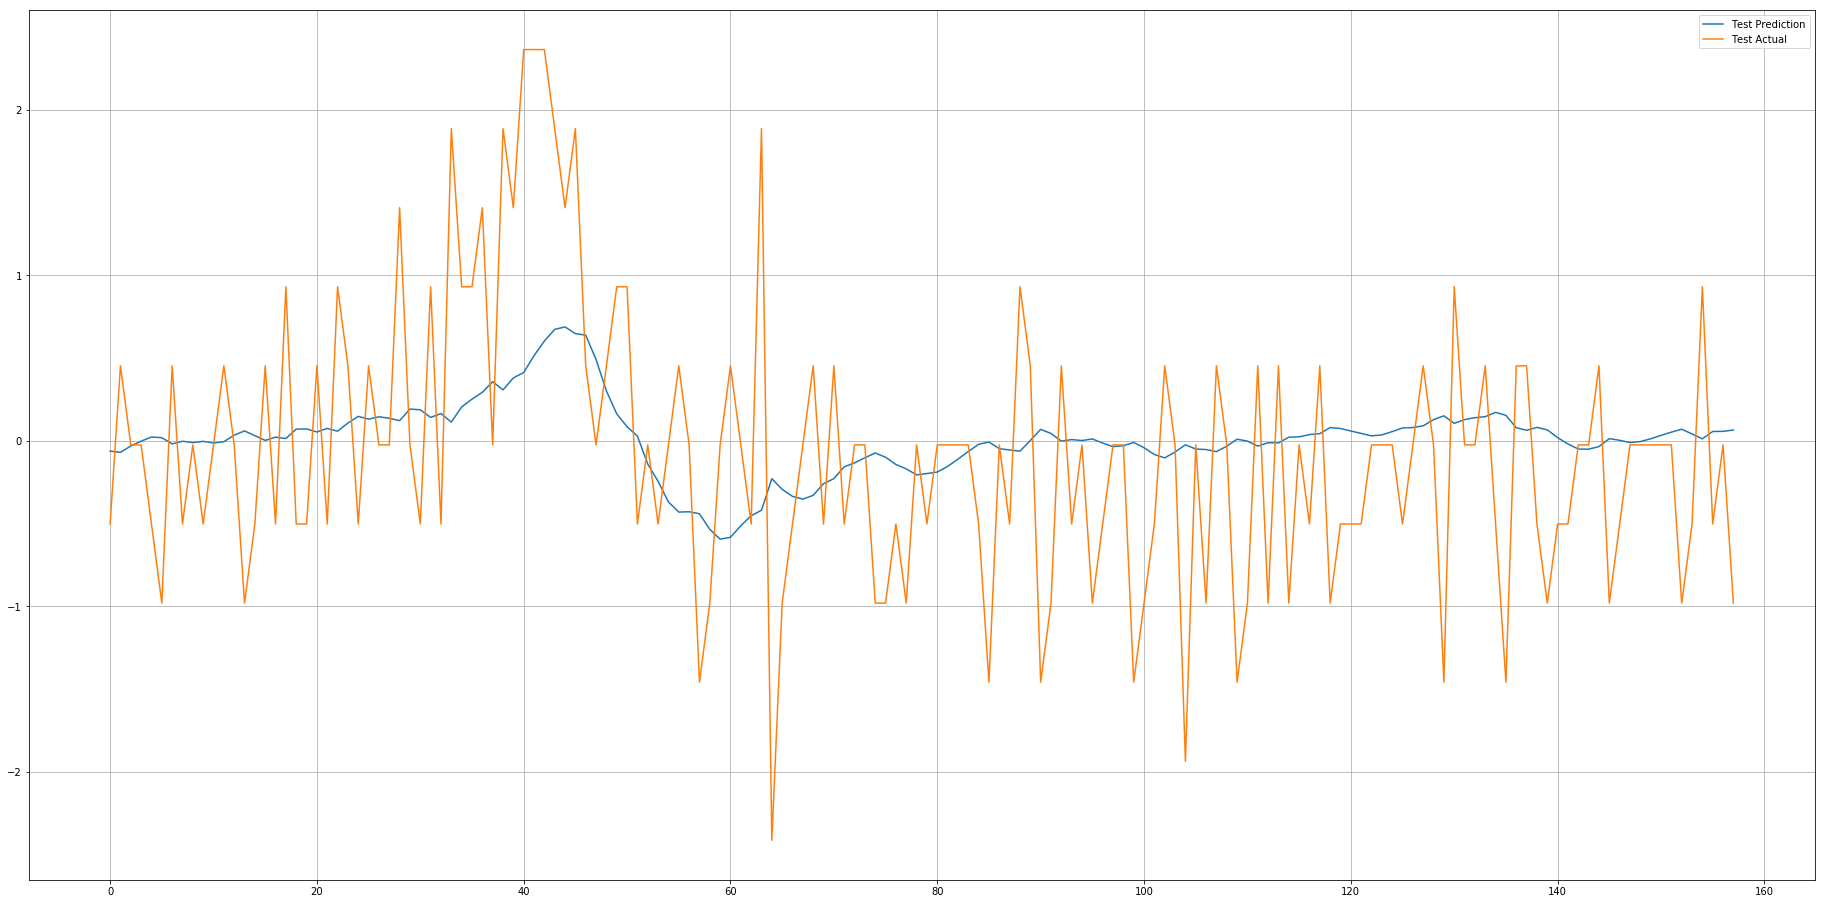

time: 587 ms


In [38]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(np.squeeze(p_test[:,-1]))
plt.plot(np.squeeze(y_test[:,-1]))
plt.legend(["Test Prediction", "Test Actual"])
plt.grid(True)
plt.show()

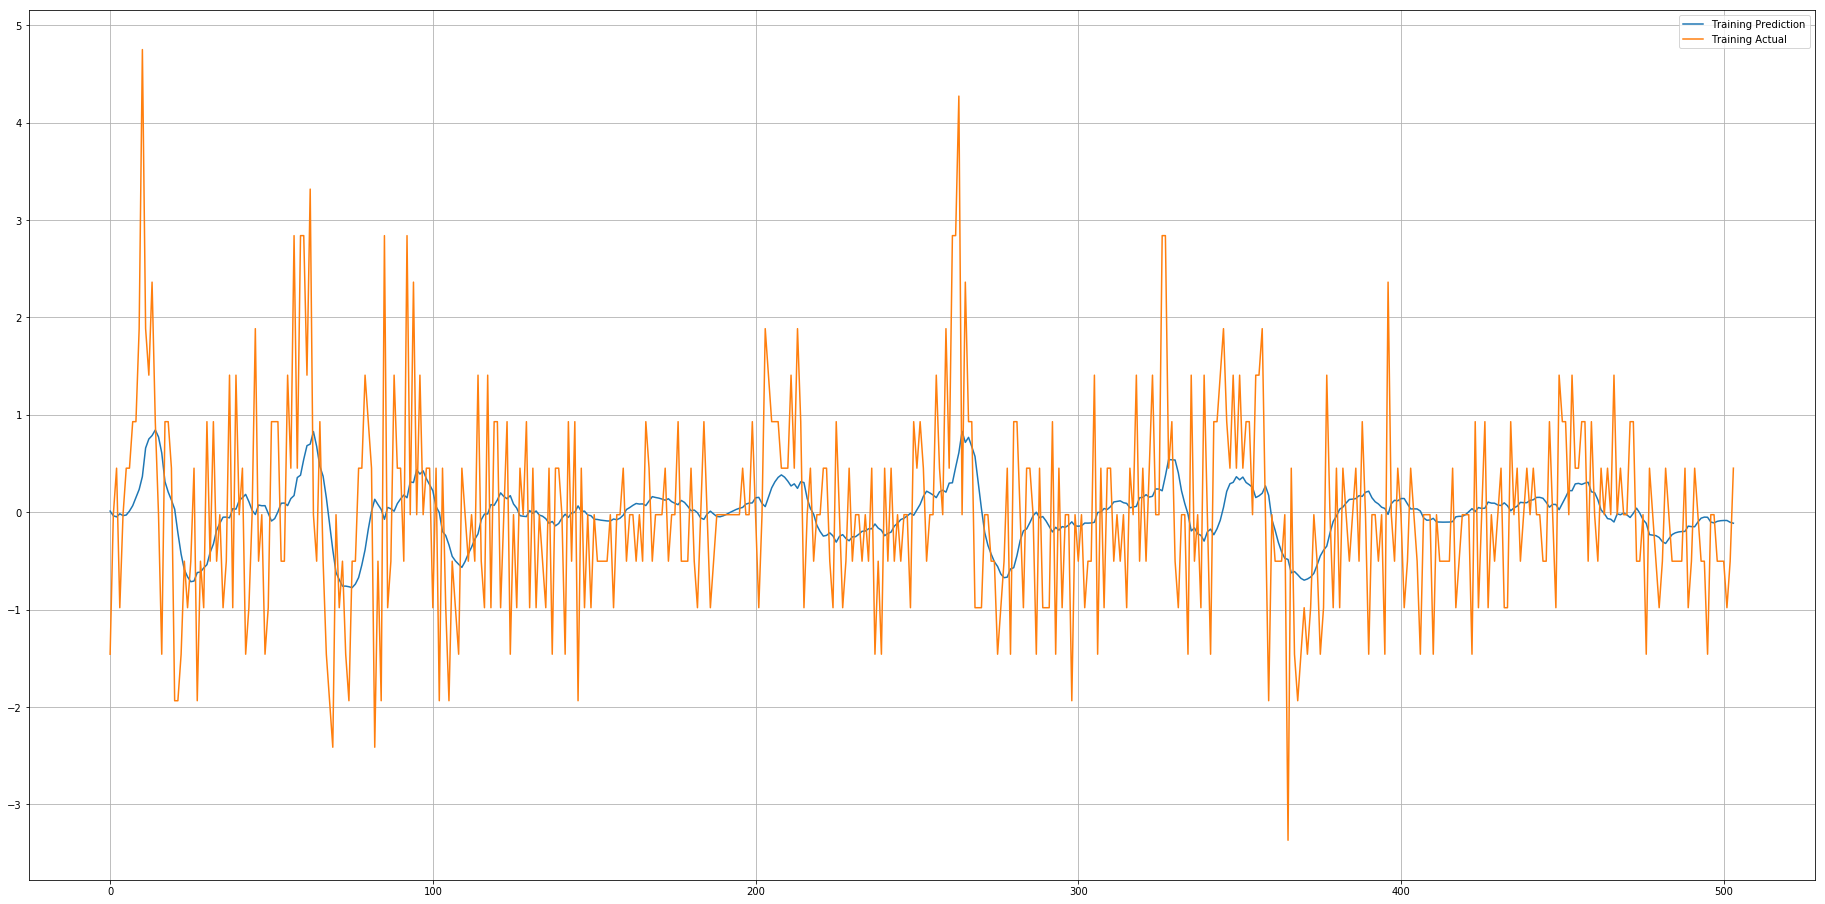

1.0000000000000004

time: 641 ms


In [41]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(np.squeeze(p_train))
plt.plot(np.squeeze(y_train[:,-1]))
plt.legend(["Training Prediction", "Training Actual"])
plt.grid(True)
plt.show()

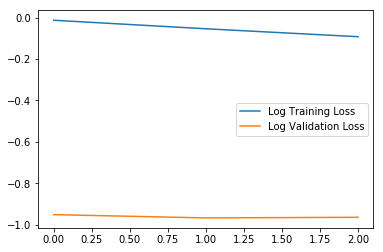

time: 129 ms


In [40]:
plt.close()
plt.plot(np.log(hist["train"]))
plt.plot(np.log(hist["val"]))
plt.legend(["Log Training Loss", "Log Validation Loss"])
plt.show()